In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this script, the analisis goes through this points:

    1. find the bifurcation point
    2. Linear fit of the two parts of the channel to refine the bifurcation point
    3. Choose weather the particles go up or down
    4. Pair the particles by NN
    5. Compute the pagnetization value of NN

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments"

filenames = [file for file in glob.glob(
    os.path.join(directory,('*_tracking.dat')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP6_2023_03_23_16_41_46_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP4_2023_03_24_11_49_16_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP4_2023_03_24_13_18_37_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP1_2023_03_22_18_12_17_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/B0_2023_03_23_11_35_12_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP2_2023_03_23_11_43_26_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with

In [3]:
name = 'B0_2023_03_23_11_36_59'

In [4]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [5]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(58,
 array([   2,    3,   20,   24,   27,   32,   42,   86,   87,   88,  114,
         148,  184,  369,  391,  400,  437,  470,  515,  575,  633,  648,
         700,  826,  844,  882,  948,  967,  988, 1043, 1073, 1085, 1107,
        1120, 1208, 1252, 1262, 1398, 1510, 1557, 1580, 1586, 1620, 1641,
        1650, 1890, 1971, 2044, 2064, 2096, 2166, 2225, 2337, 2355, 2400,
        2564, 2783, 2867]))

# Checking tracking

In [6]:
trj = trj.query('frame < 4825')

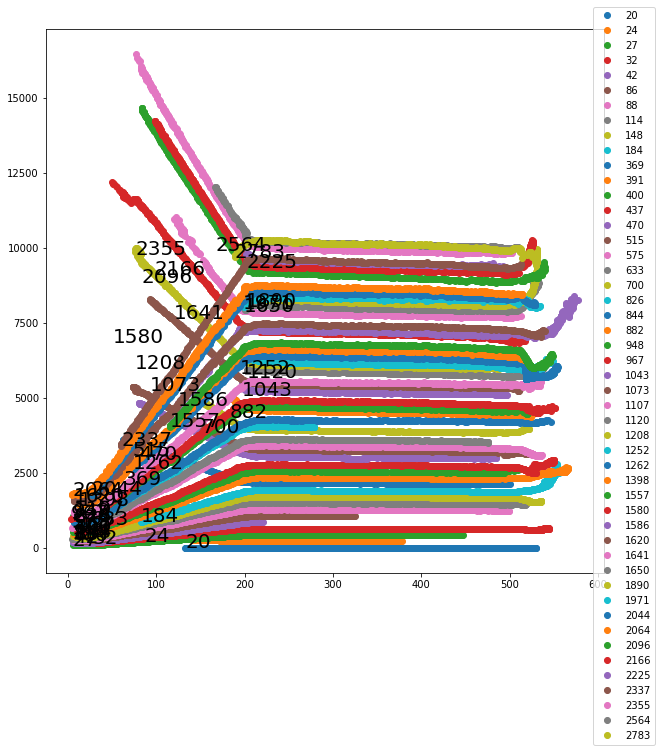

In [43]:
fig, ax = plt.subplots(1, figsize = (10,10))
i = 0
for p, gr in trj.groupby('particle'):
    
    plt.plot(gr.x, gr.y*i, 'o', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.text(gr.x.min(), gr.y.min()*i, s = str(p), size = 20)
    
    i = i+1

In [56]:
trj = trj[trj.particle != 1120 ] # To drop unuseful particles

In [57]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(48,
 array([  20,   24,   27,   32,   42,   86,   88,  114,  148,  184,  369,
         391,  400,  437,  470,  515,  575,  633,  700,  826,  844,  882,
         948,  967, 1043, 1073, 1107, 1208, 1252, 1262, 1398, 1557, 1580,
        1586, 1620, 1641, 1650, 1890, 1971, 2044, 2064, 2096, 2166, 2225,
        2337, 2355, 2564, 2783]))

# Functions used during analysis

In [58]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [59]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    
    for i in range(0,len(trj['particle'].unique())):
        
        particle = trj['particle'].unique()[i] # Select a particle trj
        
        print(particle)

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y
            
        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel

        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel
        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [60]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [61]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [62]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [63]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    d = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        d.append((np.sqrt((group.x.diff(periods=-1).values)**2 + (group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        d.append((np.sqrt((group.x.diff(periods=-1).values)**2 + (group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['distance'] = d
    
    return df

In [64]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

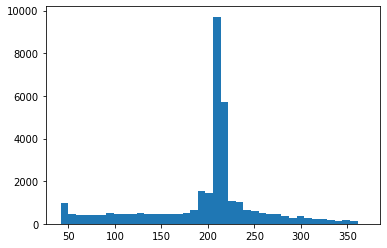

In [65]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [66]:
x_bif

186.57281026846246

In [69]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj,210, y_bif)


20
24
27
32
42
86
88
114
148
184
369
391
400
437
470
515
575
633
700
826
844
882
948
967
1043
1073
1107
1208
1252
1262
1398
1557
1580
1586
1620
1641
1650
1890
1971
2044
2064
2096
2166
2225
2337
2355
2564
2783


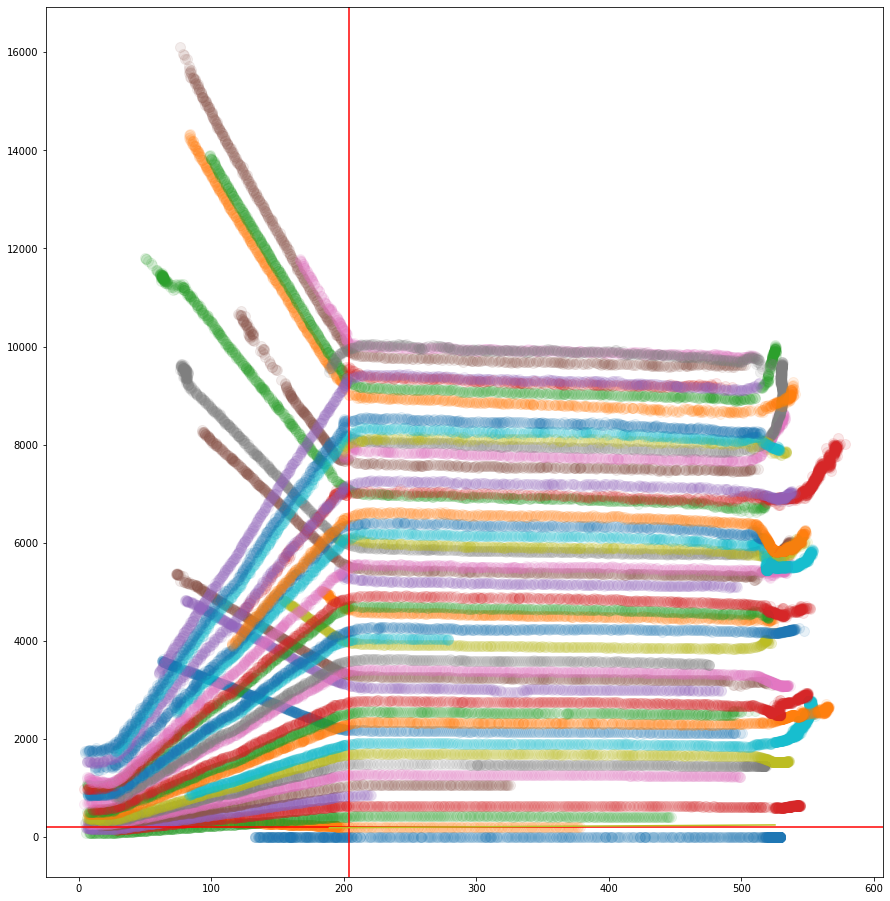

In [70]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, '.', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [71]:
fit

[poly1d([  0.17090639, 161.66609208]),
 poly1d([-1.83727581e-02,  2.21092522e+02]),
 poly1d([-1.58601805e-02,  2.17210718e+02]),
 poly1d([-2.06534554e-02,  2.18374418e+02]),
 poly1d([5.25783935e-02, 2.02077983e+02]),
 poly1d([-2.53327809e-02,  2.19832333e+02]),
 poly1d([-2.24024716e-02,  2.18711455e+02]),
 poly1d([-2.35130219e-02,  2.19555433e+02]),
 poly1d([-6.81819598e-02,  2.33374772e+02]),
 poly1d([  0.22475188, 135.01575721]),
 poly1d([-1.72731534e-02,  2.20862014e+02]),
 poly1d([6.17029522e-02, 1.91412504e+02]),
 poly1d([-1.46414225e-02,  2.16379575e+02]),
 poly1d([-1.83326767e-02,  2.17181515e+02]),
 poly1d([-1.55681361e-02,  2.20596460e+02]),
 poly1d([-2.40425996e-02,  2.23890532e+02]),
 poly1d([-5.58995361e-02,  2.29476850e+02]),
 poly1d([-2.02518821e-02,  2.18143607e+02]),
 poly1d([-3.53169839e-03,  2.17780746e+02]),
 poly1d([-1.34820010e-02,  2.16329377e+02]),
 poly1d([-1.11556050e-02,  2.15827731e+02]),
 poly1d([-2.41558731e-02,  2.23494745e+02]),
 poly1d([-2.59016688e-02, 

In [72]:
inter = up_or_down(trj,y_bif)

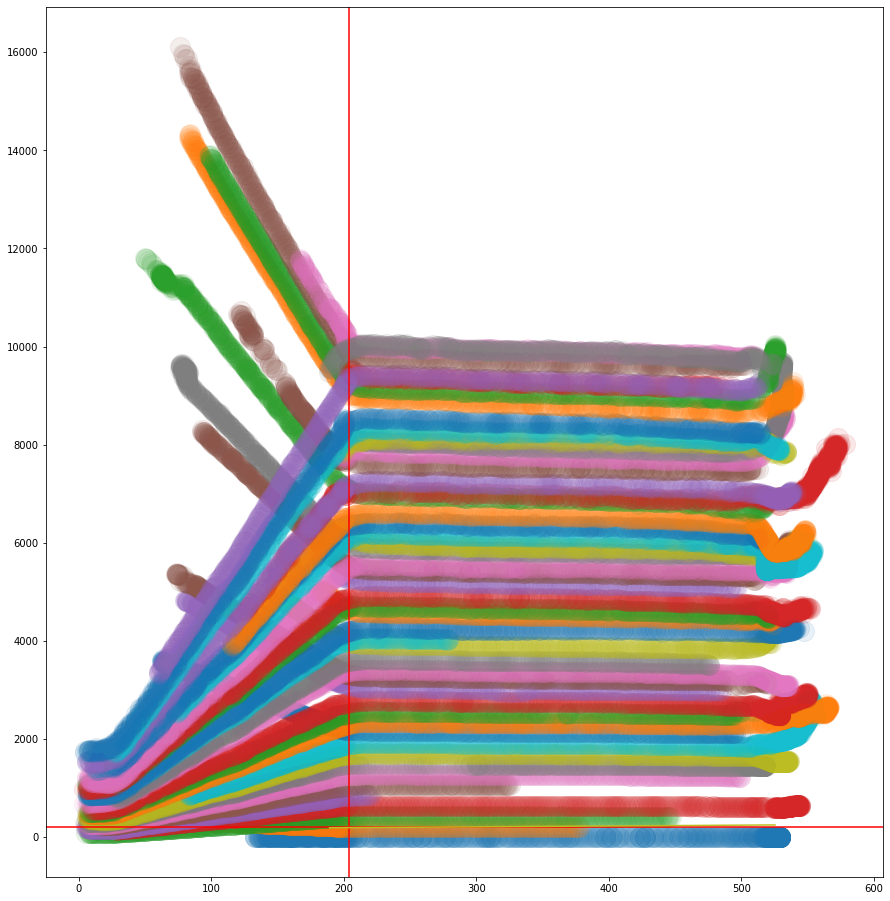

In [73]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [74]:
len(trj), len(inter)

(34449, 34449)

In [75]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

In [76]:
len(df_x), len(df_d)

(19916, 19779)

20
24
27
32
42
86
88
114
148
184
369
391
400
437
470
515
575
633
700
826
844
882
948
967
1043
1073
1107
1208
1252
1262
1398
1557
1580
1586
1620
1641
1650
1890
1971
2044
2064
2096
2166
2225
2337
2355
2564
2783


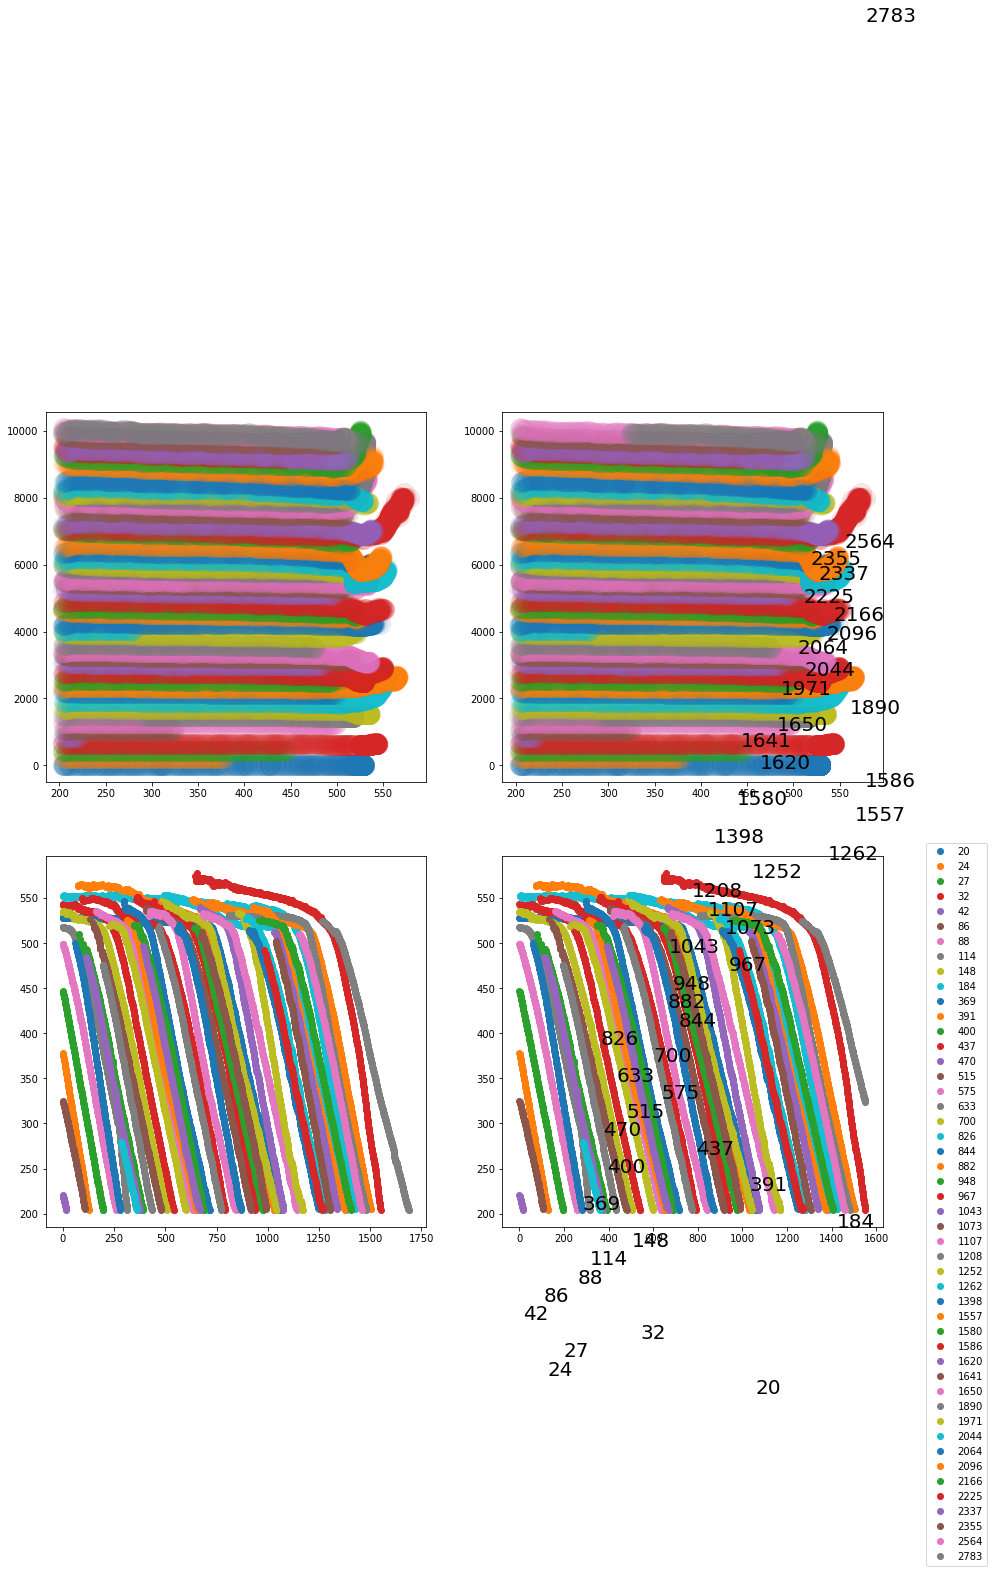

In [77]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min()*0.1*j , s = str(p), size = 20)
#     ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend(bbox_to_anchor=(1.1, 1.05))


    print(str(p))

    

    j = j+1

In [28]:
#df_d.query('frame == 3200')

In [78]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 450') # 500 is the starting point of the channel
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 23.5 s, sys: 417 ms, total: 23.9 s
Wall time: 23.6 s


In [79]:
check_analysis(trj, last)

Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs


In [80]:
len(last.particle.unique())

48

In [81]:
last.groupby(['p1','p2']).size(), len(last.groupby(['p1','p2']).size())

(p1    p2  
 20    1620    372
 24    27      256
 27    88      286
 32    700     338
 42    86       34
 86    24      216
 88    369     302
 114   470     258
       826      64
 148   32      366
 184   2564    376
 369   114     298
 391   1252    490
 400   633     334
 437   1107    352
 470   400     414
       633       4
 515   148     414
 575   882     442
 633   515     392
 700   575     408
 826   470     160
 844   1208    334
 882   948       4
       1043    426
 948   844     406
 967   1580    414
 1043  948     410
 1073  967     396
 1107  1398    360
 1208  437     412
 1252  20      464
 1262  2166    420
 1398  1073    374
 1557  1586    240
 1580  1641    432
 1586  2783    258
 1620  1650    342
 1641  391     444
 1650  1971    368
 1890  1557    382
 1971  2064    310
 2044  2355    366
 2064  2225    432
 2096  1262    426
 2166  184     378
 2225  2044    440
 2337  1262      2
       2096    420
 2355  2337    380
 2564  1890    392
 dtype: int64,
 51)

In [85]:
last1 = last1[last1.p1 != 2337] # To drop unuseful particles

In [86]:
last1.groupby(['p1','p2']).size()

p1    p2  
20    1620    372
24    27      256
27    88      286
32    700     338
42    86       34
86    24      216
88    369     302
148   32      366
184   2564    376
369   114     298
391   1252    490
400   633     334
437   1107    352
515   148     414
575   882     442
633   515     392
700   575     408
826   470     160
844   1208    334
948   844     406
967   1580    414
1043  948     410
1073  967     396
1107  1398    360
1208  437     412
1252  20      464
1262  2166    420
1398  1073    374
1557  1586    240
1580  1641    432
1586  2783    258
1620  1650    342
1641  391     444
1650  1971    368
1890  1557    382
1971  2064    310
2044  2355    366
2064  2225    432
2096  1262    426
2166  184     378
2225  2044    440
2355  2337    380
2564  1890    392
dtype: int64

In [53]:
last1 = last[(last.p1 == 24) & (last.p2 == 26)]
last1.groupby(['p1','p2']).size() 

p1  p2
24  26    2398
dtype: int64

In [52]:
last1 = last.query('p1 == 16 & p2 == 1415')


In [ ]:
last1.groupby(['p1','p2']).size() 

In [ ]:
last.groupby(['p1','p2']).size() 

In [ ]:
last1 = last[(last['p1'] == 14) & (last['p2'] == 1680)]
last1.groupby(['p1','p2']).size() 

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [87]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['d_err'] = df.groupby(['p1','p2']).distance.std()/np.sqrt(df.groupby(['p1','p2']).count()['distance'])
    
    return output

In [88]:
output = distance_and_magnetization(last1,x_bif)
output

,,frame,particle,y,x,magnetization,distance,d_err
p1,p2,,,,,,,
20,1620,966.500000,820.0,214.257179,313.664538,0.0,42.932553,0.656690
24,27,63.500000,25.5,213.547482,329.780914,0.0,78.900407,0.315225
27,88,126.000000,57.5,211.623688,328.632459,1.0,75.994809,0.121159
32,700,456.029586,366.0,214.036984,327.937956,0.0,62.440308,0.138872
42,86,8.000000,64.0,212.375606,264.862159,1.0,104.641331,0.074751
86,24,53.500000,55.0,214.203661,285.916174,0.0,36.657313,0.566663
88,369,184.000000,228.5,213.471012,317.716072,0.0,46.022891,0.521276
148,32,415.000000,90.0,211.803533,322.082494,1.0,42.928266,0.143543
184,2564,1331.500000,1374.0,213.662922,332.490622,0.0,32.427267,0.309246


In [89]:
output.to_csv('magnetization_'+name+'.dat', sep = '\t')